## Initialization

In [ ]:
import os
import grasp
import numpy as np
import pandas as pd
from astropy import units as u
from matplotlib import pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')

try:
    device_name = os.getenv('COMPUTERNAME')
    if device_name == 'DESKTOP-Work':
        tn1 = '20250506_170539'
        tn2 = '20250506_170541'
        tn3 = '20250515_193141'
        acs = grasp.load_data(tn = tn1)
        pcs = grasp.load_data(tn = tn2)
        fas = grasp.load_data(tn = tn3)
    elif device_name == 'LAPTOP-Work':
        tn1 = '20250401_164228'
        tn2 = '20250401_164231'
        tn3 = '20250515_094935'
        pcs = grasp.load_data(tn = tn1, data_format='ascii.tab', file_format='.txt')
        acs = grasp.load_data(tn = tn2, data_format='ascii.tab', file_format='.txt')
        fas = grasp.load_data(tn = tn3)
    else:
        raise EnvironmentError("Unknown device name")
    acs.gc = pcs.gc = fas.gc = gc
except FileNotFoundError as e:
    print(e)
    astrometry_query = "SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                        radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND abs(parallax_error/parallax)<0.50\
                        AND abs(pmra_error/pmra)<0.30 \
                        AND abs(pmdec_error/pmdec)<0.30 \
                        AND pmra IS NOT NULL AND abs(pmra)>0 \
                        AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.214805 AND -17.807517"
    
    photometry_query = "SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                        bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND ruwe < 1.15 \
                        AND phot_g_mean_mag > 11 \
                        AND astrometric_excess_noise_sig < 2 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.2148 AND -17.807517"
    acs = dr3.free_query(astrometry_query, save=True)
    acs = grasp.Sample(acs, gc)
    pcs = dr3.free_query(photometry_query, save=True)
    pcs = grasp.Sample(pcs, gc)
    fas = dr3.get_astrometry(1., 'ngc6121', save=True)
    print("\nWARNING! Remember to updates tn after running the new query!!!")


            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'
Not a Cluster: no model available
Not a Cluster: no model available


In [3]:
aps = acs.join(pcs)
aps.gc.dist = 1851 * u.pc # Baumgardt, Vasiliev: 2021 # pc
f = grasp.load_base_formulary()
aps.info()

<Sample length=1014>
          name            dtype     class     n_bad
------------------------ ------- ------------ -----
               SOURCE_ID   int64       Column     0
                      ra float64       Column     0
                ra_error float32       Column     0
                     dec float64       Column     0
               dec_error float32       Column     0
                parallax float64       Column     0
          parallax_error float32       Column     0
                    pmra float64       Column     0
              pmra_error float32       Column     0
                   pmdec float64       Column     0
             pmdec_error float32       Column     0
         radial_velocity float32 MaskedColumn   923
   radial_velocity_error float32 MaskedColumn   923
                   bp_rp float32 MaskedColumn    31
         phot_g_mean_mag float32 MaskedColumn     1
        phot_bp_mean_mag float32 MaskedColumn   118
        phot_rp_mean_mag float32 MaskedColu

# MachineLearning

## Golden-Sample XDGMM

### PMRA ($\mu_\alpha$) 
KDE mean

Correctly imported `minpack.lm`.


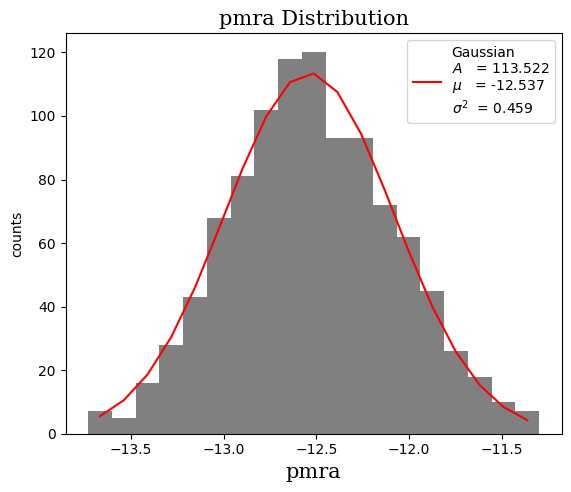

pmra_mean = -12.5372


In [4]:
pmra = aps.pmra
pmra_kde = grasp.plots.histogram(pmra, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmra_mean = pmra_kde[1]
print(f"{pmra_mean = :.4f}")

### PMDEC ($\mu_{\delta^*}$) 
KDE mean

Correctly imported `minpack.lm`.


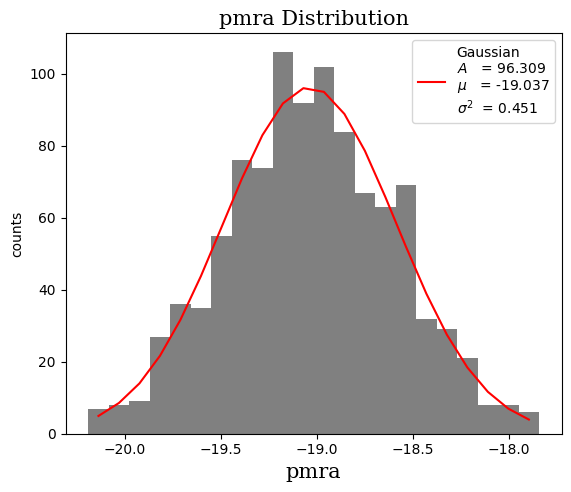

pmdec_mean = -19.0371


In [5]:
pmdec = aps.pmdec
pmdec_kde = grasp.plots.histogram(pmdec, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmdec_mean = pmdec_kde[1]
print(f"{pmdec_mean = :.4f}")

### XDGMM (eXtreme Deconvolution Gaussian Mixture Model)

For cluster parameters estimation from subsample, to be checked with PM regression and with clustering classification

In [6]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
f.substitute(
    "Angular separation",
    {"alpha_{0}": aps.gc.ra.to(u.rad).value, "delta_{0}": aps.gc.dec.to(u.rad).value},
)
theta_GC = f.compute(
    "Angular Separation",
    data={"alpha_{1}": ra, "delta_{1}": dec},
    errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error},
    asarray=True,
)

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Errors:       [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations: [rho_alpha_{1}_delta_{1}]
------------------------------
Errors:
Computation using all 16 cores.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as ac, mean_absolute_error as mea, mean_squared_error as mse

data = np.array([aps.SOURCE_ID, aps.pmra, aps.pmdec, theta_GC[0]]).T
errors = np.array([aps.SOURCE_ID, aps.pmra_error, aps.pmdec_error, theta_GC[1]]).T
correlation = aps.pmra_pmdec_corr.value

In [8]:
X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2)
if all(X_train[:,0] == err_train[:,0]) and all(X_test[:,0] == err_test[:,0]):
    print("Data and errors are aligned.\nRemoving source_id column...\n")
    err_train = np.delete(err_train, 0, axis=1)
    err_test = np.delete(err_test, 0, axis=1)
    X_train = np.delete(X_train, 0, axis=1)
    X_test = np.delete(X_test, 0, axis=1)
else:
    print("Data and errors are not aligned. Exiting...")
    exit(1)
print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
print(f"{err_train.shape = :}")
print(f"{err_test.shape = :}")
print(f"\n{corr_train.shape = :}")
print(f"{corr_test.shape = :}\n")

Data and errors are aligned.
Removing source_id column...

X_train.shape = (811, 3)
X_test.shape = (203, 3)

err_train.shape = (811, 3)
err_test.shape = (203, 3)

corr_train.shape = (811,)
corr_test.shape = (203,)



In [9]:
train_cov = grasp.stats._construct_covariance_matrices(err_train, {(0,1): corr_train})
test_cov = grasp.stats._construct_covariance_matrices(err_test, {(0,1): corr_test})
print(f"{train_cov.shape = :}")
print(f"{test_cov.shape = :}\n")

train_cov.shape = (811, 3, 3)
test_cov.shape = (203, 3, 3)



In [10]:
model = grasp.stats.XD_estimator(data=X_train, errors=err_train, correlations={(0,1): corr_train}, n_components=1)

In [11]:
xdgmm_pmra_mean, xdgmm_pmdec_mean, _ = tuple([mu[0] for mu in model.mu.T])
print(f"{pmra_mean = :.3f} mas/yr\n{pmdec_mean = :.3f} mas/yr")

pmra_mean = -12.537 mas/yr
pmdec_mean = -19.037 mas/yr


In [12]:
print(f"{xdgmm_pmra_mean/pmra_mean*100 = :.3f} %")
print(f"{xdgmm_pmdec_mean/pmdec_mean*100 = :.3f} %")

xdgmm_pmra_mean/pmra_mean*100 = 99.948 %
xdgmm_pmdec_mean/pmdec_mean*100 = 99.986 %


## GMM on Full Sample

### Feature Engeneering

In [ ]:
fas = dr3.free_gc_query(
    1.2,
    'ngc6121', 
    data = 'source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error,ra_dec_corr,pmra_pmdec_corr',
    save=True
)
Ni = len(fas)
fas.join(aps, keep='left_only', inplace=True)
Nf = len(fas)
assert Ni-Nf == len(aps), f"Number of sources in fas ({Ni-Nf}) is not equal to the number of sources in aps ({len(aps)})"

fas.drop_columns(
    [
        "radial_velocity",
        "radial_velocity_error",
        "bp_rp",
        "phot_g_mean_mag",
        "teff_gspphot",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "phot_bp_rp_excess_factor"
    ]
)

fas.dropna()

Key error: 'Scan_Info'
Key error: 'Scan_Info'
Key error: 'Scan_Info'
Key error: 'Scan_Info'
Key error: 'Scan_Info'
INFO: Query finished. [astroquery.utils.tap.core]
Sample number of sources: 314663
/home/pietrof/graspdata/query/NGC6121/20250515_193141/query_data.fits
/home/pietrof/graspdata/query/NGC6121/20250515_193141/query_info.ini


Correctly imported `minpack.lm`.


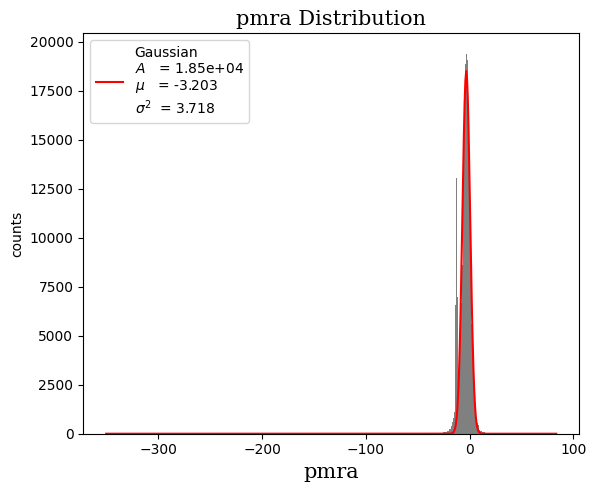

Correctly imported `minpack.lm`.


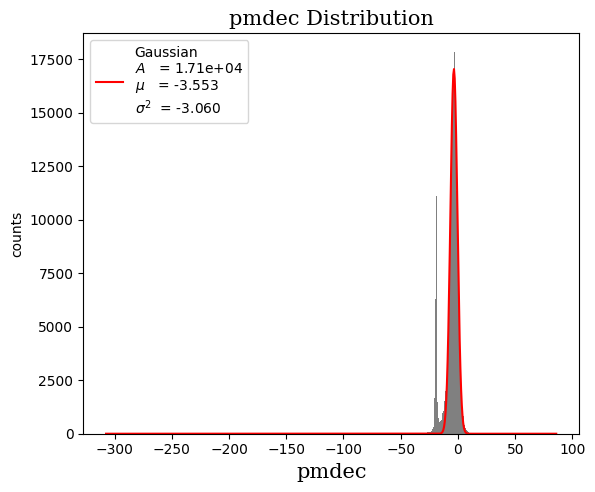

In [14]:
pmra_dist = grasp.plots.histogram(fas['pmra'].value, kde=True ,xlabel='pmra', out=True)
pmdec_dits = grasp.plots.histogram(fas['pmdec'].value, kde=True ,xlabel='pmdec', out=True)

Removing extreme outliers

In [15]:
fas.apply_conditions(
    conditions={
        "pmra": f"<50",
        "pmra": f">-50",
        "pmdec":f"<50",
        "pmdec":f">-50",
    },
    inplace=True,
)

Data sample for cluster NGC6121

 Data Columns:                                              
-------------------------------------------------------------------------
 source_id         ra     ra_error     dec     dec_error     parallax
 parallax_error    pmra   pmra_error   pmdec   pmdec_error   ra_dec_corr
 pmra_pmdec_corr                                            


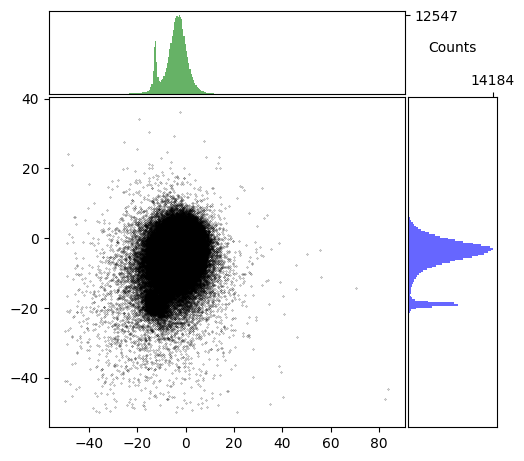

In [16]:
grasp.plots.doubleHistScatter(fas.pmra, fas.pmdec, size=0.05, alpha=0.85)

In [17]:
#f.var_order('angular separation')
fas['ang_sep'], fas['ang_sep_error'] = f.compute('angular separation',
          data={'alpha_{1}': (fas.ra*u.deg).to(u.rad).value, 'delta_{1}': (fas.dec*u.deg).to(u.rad).value}, 
          errors={"epsilon_alpha_{1}": (fas.ra_error*u.deg).to(u.rad).value, "epsilon_delta_{1}": (fas.dec_error*u.deg).to(u.rad).value}, 
          corrs={'rho_alpha_{1}_delta_{1}': fas.ra_dec_corr},
          asarray=True)

fas[['ang_sep', 'ang_sep_error']].describe()

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Errors:       [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations: [rho_alpha_{1}_delta_{1}]
------------------------------
Errors:


,ang_sep,ang_sep_error
count,250764.000000,250764.000000
mean,0.012392,0.006229
std,0.005833,0.005399
min,0.000002,0.000103
25%,0.008122,0.002262
50%,0.013421,0.004737
75%,0.017238,0.008627
max,0.020944,0.054418


### Model1: GMM with  $\,\forall \bar{\omega} \in \mathcal{R}$

In [21]:
data = fas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
# errors = fas[['ra_error','dec_error','pmra_error','pmdec_error','parallax_error']].to_numpy()
# correlation = fas['pmra_pmdec_corr']

# X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2)
X_train, X_test = train_test_split(data, test_size=0.33)

print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
# print(f"{err_train.shape = :}")
# print(f"{err_test.shape = :}")
# print(f"\n{corr_train.shape = :}")
# print(f"{corr_test.shape = :}\n")

X_train.shape = (168011, 5)
X_test.shape = (82753, 5)



In [22]:
model1 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%


Text(0.5, 1.0, 'Model1: G=3 with full parallaxes')

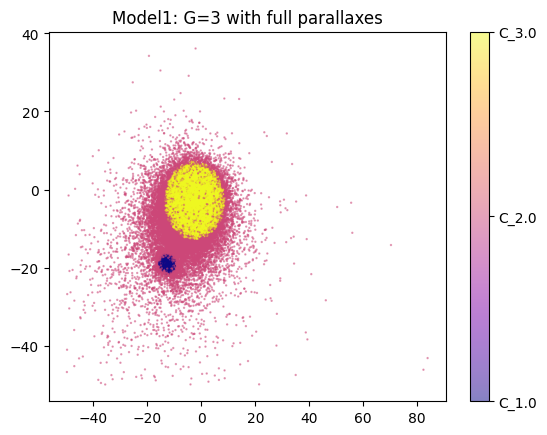

In [47]:
plt.scatter(X_train[:,2], X_train[:,3], c=model1.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model1.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model1.train_classification['classification'])])
plt.title('Model1: G=3 with full parallaxes')

In [25]:
pd.DataFrame(data=model1.train_classification['classification']).value_counts()

0  
3.0    127959
2.0     24015
1.0     16037
Name: count, dtype: int64

In [26]:
model1_parameters = pd.DataFrame(data=model1.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model1_parameters)

            ra        dec       pmra      pmdec  parallax
G1  245.897465 -26.527201 -12.518237 -19.011276  0.526100
G2  245.973258 -26.572621  -5.651875  -7.603651  0.635502
G3  246.024004 -26.598138  -2.972630  -3.514911  0.288357


In [27]:
predictions = model1.predict(X_test)

Correctly imported `mclust`.


Text(0.5, 1.0, 'Model1 Test Set')

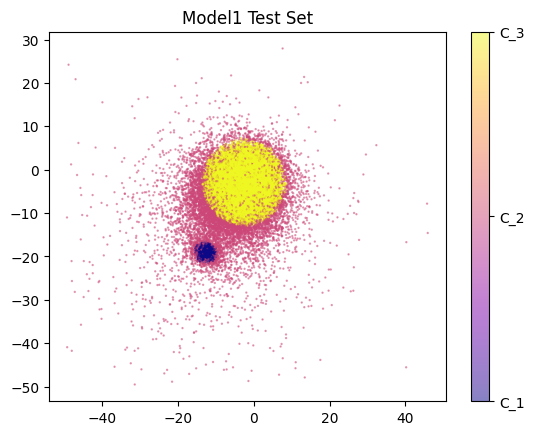

In [48]:
plt.scatter(X_test[:,2], X_test[:,3], c=predictions['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions['classification'])])
plt.title('Model1 Test Set')

### Model2: GMM with $\,\forall\bar{\omega}\in\mathcal{R}^+$

In [36]:
pfas = fas.apply_conditions('parallax>0', inplace=False)
print(f"Parallax cleaned sample is {len(pfas)/len(fas)*100:.2f} % of the original sample")

Parallax cleaned sample is 75.30 % of the original sample


In [37]:
data2 = pfas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
X_train2, X_test2 = train_test_split(data2, test_size=0.33)

print(f"{X_train2.shape = :}")
print(f"{X_test2.shape = :}\n")

X_train2.shape = (126506, 5)
X_test2.shape = (62309, 5)



In [38]:
model2 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%


0  
1.0    90585
2.0    21452
3.0    14469
Name: count, dtype: int64

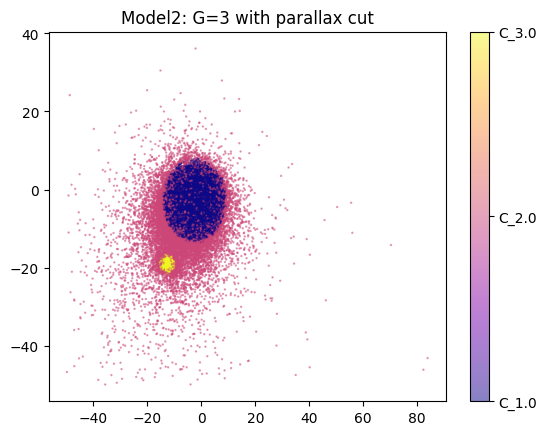

In [49]:
plt.scatter(X_train2[:,2], X_train2[:,3], c=model2.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model2.train_classification['classification'])])
plt.title('Model2: G=3 with parallax cut')

pd.DataFrame(data=model2.train_classification['classification']).value_counts()

In [40]:
model2_parameters = pd.DataFrame(data=model2.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model2_parameters)

            ra        dec       pmra      pmdec  parallax
G1  246.017872 -26.597791  -2.948604  -3.507640  0.475196
G2  245.967121 -26.578167  -5.506222  -7.594985  1.617928
G3  245.897117 -26.526894 -12.514878 -19.014260  0.579888


In [42]:
predictions2 = model2.predict(X_test2)

Correctly imported `mclust`.


Text(0.5, 1.0, 'Model2 Test Set')

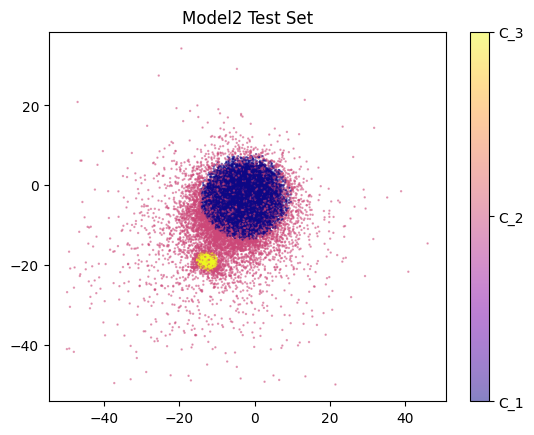

In [50]:
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions2['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions2['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions2['classification'])])
plt.title('Model2 Test Set')

### Model3: only 2 gaussian components with $\forall\bar{\omega}\in\mathcal{R}^+$

In [44]:
model3 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%


0  
1.0    111692
2.0     14814
Name: count, dtype: int64

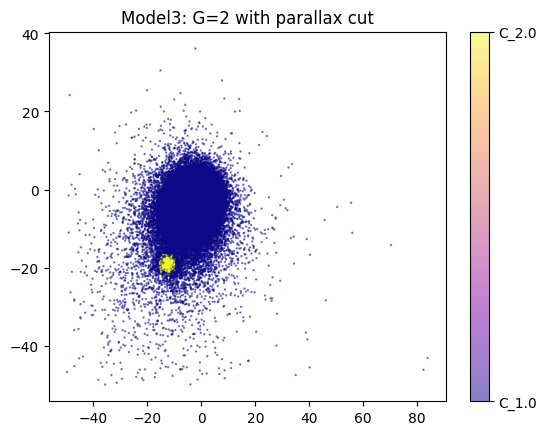

In [52]:
plt.scatter(X_train2[:,2], X_train2[:,3], c=model3.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model3.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model3.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model3.train_classification['classification']).value_counts()

In [54]:
predictions3 = model3.predict(X_test2)
model3_parameters = pd.DataFrame(data=model3.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model3_parameters)

Correctly imported `mclust`.
            ra        dec       pmra      pmdec  parallax
G1  246.007266 -26.593773  -3.470708  -4.341481  0.720262
G2  245.897158 -26.526898 -12.518368 -19.018366  0.597719


Text(0.5, 1.0, 'Model3 Test Set')

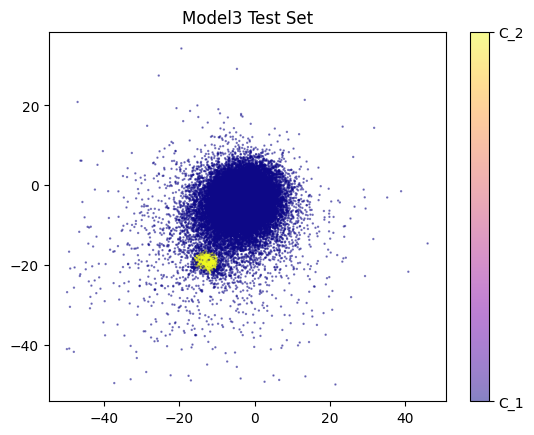

In [55]:
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions3['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions3['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions3['classification'])])
plt.title('Model3 Test Set')

### KFold Cross-Validation with GMM

In [79]:
nfolds = 20
kfold_model = grasp.stats.kfold_gmm_estimator(
    data=data2,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=True
)

Correctly imported `mclust`.
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |====================================

Model's BIC Variance: 0.0826 %


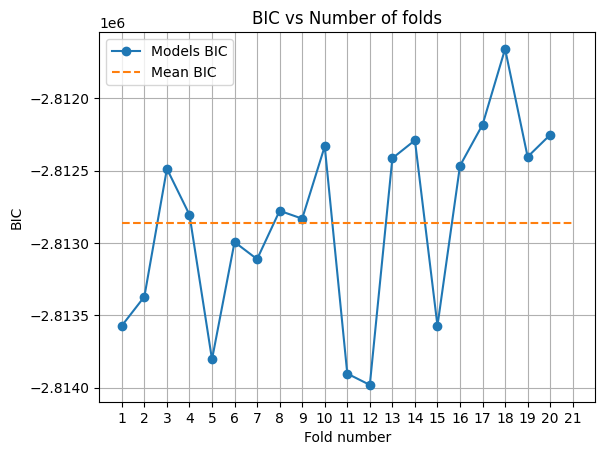

In [96]:
plt.plot(np.arange(1,nfolds+1), kfold_model.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfold_model.mean_bic,kfold_model.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfold_model.bics) - np.max(kfold_model.bics))/np.max(kfold_model.bics) * 100:.4f} %")

Try with 2 Cluster members

In [97]:
nfolds = 20
kfold_model2 = grasp.stats.kfold_gmm_estimator(
    data=data2,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=True
)

Correctly imported `mclust`.
[1] "Fold 1"
fitting ...
  |======================================================================| 100%
[1] "Fold 2"
fitting ...
  |======================================================================| 100%
[1] "Fold 3"
fitting ...
  |======================================================================| 100%
[1] "Fold 4"
fitting ...
  |======================================================================| 100%
[1] "Fold 5"
fitting ...
  |======================================================================| 100%
[1] "Fold 6"
fitting ...
  |======================================================================| 100%
[1] "Fold 7"
fitting ...
  |======================================================================| 100%
[1] "Fold 8"
fitting ...
  |======================================================================| 100%
[1] "Fold 9"
fitting ...
  |======================================================================| 100%
[1] "Fold 10"
fitting ...


Model's BIC Variance: 0.1275 %


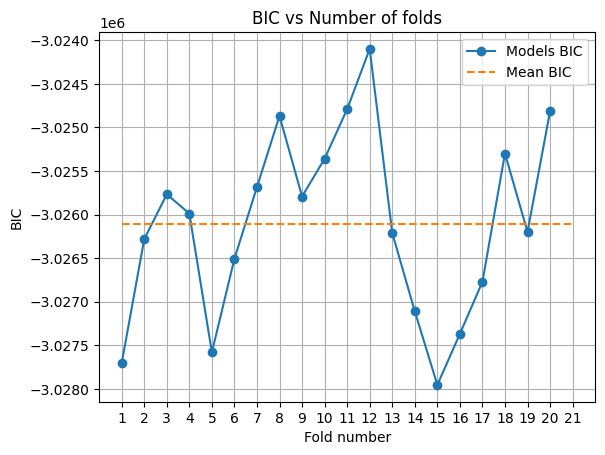

In [99]:
plt.plot(np.arange(1,nfolds+1), kfold_model2.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfold_model2.mean_bic,kfold_model2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfold_model2.bics) - np.max(kfold_model2.bics))/np.max(kfold_model2.bics) * 100:.4f} %")

# Riassunto

Rifare il training sul dataset completo dopo:
- Aver pulito i dati da outliers nello spazio dei PM (sono inutili)
- RA - DEC ci dice qualcosa? 
- Togliere la AngularSeparation - potrebbe introdurre un bias, visto che è calcolato su RA-DEC arbitrari (forse andrebbe calcolato sui parametri trovati da XDGMM)

# Analisi Separazione Angolare

In [ ]:
grasp.plots.colorMagnitude(aps)

In [ ]:
grasp.plots.histogram(aps.parallax, bins='detailed')

In [ ]:
grasp.plots.doubleHistScatter(aps.ra, aps.dec, xlabel='RA', ylabel='Dec')

## Angular Separation Analysis

The `Great Circle` formula versus the `Vincenty Formula` for the computation of distances on a sphere

### $\theta_V$ vs $\theta_{GC}$ vs $\theta_{G}$

In [ ]:
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.to(u.rad).value, 'delta_{0}':aps.gc.dec.to(u.rad).value})

from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1) * sin((alpha_0 - alpha_1)/2))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.to(u.rad).value, 'delta_0':aps.gc.dec.to(u.rad).value})


f.angular_separation

In [ ]:
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.to(u.rad).value, 'delta_{0}':aps.gc.dec.to(u.rad).value})
theta_GC = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error}, asarray=True)

In [ ]:
f['Vincenty angsep']

In [ ]:
f.var_order('Angular Separation')
print('')
f.var_order('Vincenty angsep')

In [ ]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
print("Great Circle Distance computation\n")
theta_GC = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error}, asarray=True)
print("\nVincenty Distance computation\n")
theta_V = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec}, asarray=True)

grasp.plots.doubleHistScatter(theta_V, theta_GC[0], xlabel='Vincenty Formula', ylabel='Angular Separation')

In [ ]:
t_ratio = theta_V/theta_GC[0]
err_t = (1-t_ratio) * 100
out = grasp.plots.histogram(err_t, bins='knuth', kde=True, kde_kind='lorentzian', xlabel=r'$\theta_V\,/\,\theta_GC$', out=True)
fit = out['kde']
print(f"A = {fit[0]:.2f}  ;  lambda = {fit[1]:.2f}")

### ADQL computed Angular Separation : $\theta_{G}$

Validated! <br>
It is shown how the angular separation computed from the ADQL language corresponds to the
Great Circle formula used by the GRASP package.

In [ ]:
query1: str = "SELECT source_id, DISTANCE(245.897,-26.526, ra, dec) AS ang_sep \
    FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
    AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
    AND abs(parallax_error/parallax)<0.50\
    AND abs(pmra_error/pmra)<0.30 \
    AND abs(pmdec_error/pmdec)<0.30 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0 \
    AND pmra BETWEEN -13.742720 AND -11.295338 \
    AND pmdec BETWEEN -20.214805 AND -17.807517"

query2: str = "SELECT source_id, DISTANCE(245.897,-26.526, ra, dec) AS ang_sep  \
    FROM gaiadr3.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
    AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
    AND ruwe < 1.15 \
    AND phot_g_mean_mag > 11 \
    AND astrometric_excess_noise_sig < 2 \
    AND pmra BETWEEN -13.742720 AND -11.295338 \
    AND pmdec BETWEEN -20.2148 AND -17.807517"

acs2 = grasp.Sample(dr3.free_query(query1), gc='ngc6121')
pcs2 = grasp.Sample(dr3.free_query(query2), gc='ngc6121')

In [ ]:
aps2 = acs2.join(pcs2)
aps2.gc.dist = 1851 * u.pc
aps2.info()

In [ ]:
theta_G = (aps2.ang_sep*u.deg).to(u.rad).value
grasp.plots.doubleHistScatter(theta_GC[0], theta_G, bins='knuth', xlabel=r"$\theta_GC$", ylabel=r"$\theta_G$")

### $r_{2D}(\theta_V)$ vs $r_{2D}(\theta_{GC})$

In [ ]:
f.substitute('radial_distance_2d', {'r_{c}': aps.gc.dist.value})
f.radial_distance_2d

In [ ]:
f.var_order('radial_distance_2d')

In [ ]:
print(r'Computation using $\theta_{GC}$')
r2d_GC = f.compute('radial_distance_2d', data={'theta': theta_GC[0]}, errors = {'epsilon_theta': theta_GC[1]}, asarray=True) # Great Circle
print('')
print(r'Computation using $\theta_{V}$')
r2d_V = f.compute('radial_distance_2d', data={'theta': theta_V}, asarray=True) # Vincenty Formula

r_ratio = r2d_V/r2d_GC[0]

In [ ]:
grasp.plots.doubleHistScatter(r2d_V, r2d_GC[0], xlabel=r'$r_{2d}(\theta_{V})$ [pc]', ylabel=r'$r_{2d}(\theta_{GC})$ [pc]')

In [ ]:
grasp.plots.histogram(1-r_ratio[r_ratio<400], kde=True, kde_kind='lorentzian', xlabel=r'$r_{2d}(\theta_{V})\,/\,r_{2d}(\theta_{GC})$')

## Radial Distance $R$

### Computing $d$ and $r_x$

In [ ]:
f.los_distance

In [ ]:
f.gc_z_coordinate


In [ ]:
f.radial_distance_3d

In [ ]:
rt_pc = np.tan(aps.gc.rt.to(u.rad).value) * aps.gc.dist.to(u.pc)
print(f"Tidal radius of {aps.gc.id} = {rt_pc:.2f}")

In [ ]:
f.var_order('los_distance')
f.var_order('gc_z_coordinate')
f.substitute('gc_z_coordinate', {'r_{c}': aps.gc.dist.value})
print('')
r_x = f.compute('los_distance', data={'omega': aps.parallax}, errors={"epsilon_omega": aps.parallax_error}, asarray=True) * 1000
print('')
d = f.compute('gc_z_coordinate',data={'r_{x}': r_x[0]}, errors={'epsilon_r_{x}': r_x[1]}, asarray=True)

### $R(\theta_{GC}$)

In [ ]:
f.var_order('radial_distance_3d')

In [ ]:
R_GC = f.compute('radial_distance_3d', {'d': d[0],'r_{2}': r2d_GC[0]}, errors={"epsilon_d": d[1], "epsilon_r_{2}": r2d_GC[1]}, asarray=True)
rgc_hist = grasp.plots.histogram(R_GC[0], xlabel=r'$R(\theta_{GC})$', kde=True, kde_kind='gaussian', out=True, kde_verbose=False)

In [ ]:
grasp.plots.errorbar(R_GC[0], dataerr=R_GC[1], x=R_GC[0])

In [ ]:
grasp.plots.histogram(R_GC[1], xlabel=r"$R_{GC}$ Error", bins='knuth')

**Conclusions**

The vincenty formula computes the angular separation between two points on an ellipsoid, so, in the case of computing<br>
angular separations between stars in the celestial sphere, which geometry is, effectively, a unit sphere, the Great Circle<br>
formula is the correct one to use, as it computes the distances on a spheric geometry<br>

*Overall*, defined the ratio 

> $\bar{r} = \dfrac{R(\theta_{V})}{R(\theta_{GC})}$

its mean and standard deviation

> $\big<\bar{r}\big> = 0.96$

> $\sigma(\bar{r}) = 0.08$

indicates that, for the problem at hand, the two equations provide almost equal results, provided some outlier data.

In the end, using the GC formula is recommended, as it is computed on the actual geometry we are considering